In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# 전처리 
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import datetime
import os
import itertools

from sklearn.preprocessing import StandardScaler,minmax_scale

# 시각화
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

# 모델 
import fbprophet as Prophet
from sklearn.linear_model import LinearRegression, Ridge

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU


# 보간
from scipy import interpolate
from scipy.interpolate import splrep, splev

'구분'은 공급사이지만 영업 비밀에 해당하여 비식별화 처리된 데이터이고,  
'공급량'은 영업비밀에 해당하여 원데이터와 유사한 패턴을 갖도록 처리된 데이터입니다.

# 전처리
- 공급사 구분 분류
- train, test 나누기

In [ ]:
path="/gdrive/My Drive/Colab Notebooks/dacon/gas_supply"
train_df=pd.read_csv(path+"/train.csv",encoding='cp949')
test_df=pd.read_csv(path+"/test.csv")
sample_df=pd.read_csv(path+"/sample_submission.csv")

train_size=len(train_df)
test_size=len(test_df)

L=['A', 'B', 'C', 'D', 'E', 'G', 'H']
location_size=len(L)

train_size_per=int(train_size/location_size)
test_size_per=int(test_size/location_size)

df_dict={}
for t in L:
    df_dict[t]=train_df[train_df["구분"]==t]
    df_dict[t]=df_dict[t].reset_index().drop(["index"],axis="columns")

display(df_dict["A"])
display(test_df)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
52579,2018-12-31,20,A,3040.868
52580,2018-12-31,21,A,2973.577
52581,2018-12-31,22,A,2840.272
52582,2018-12-31,23,A,2692.385


,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A
...,...
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H


# EDA

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


A


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



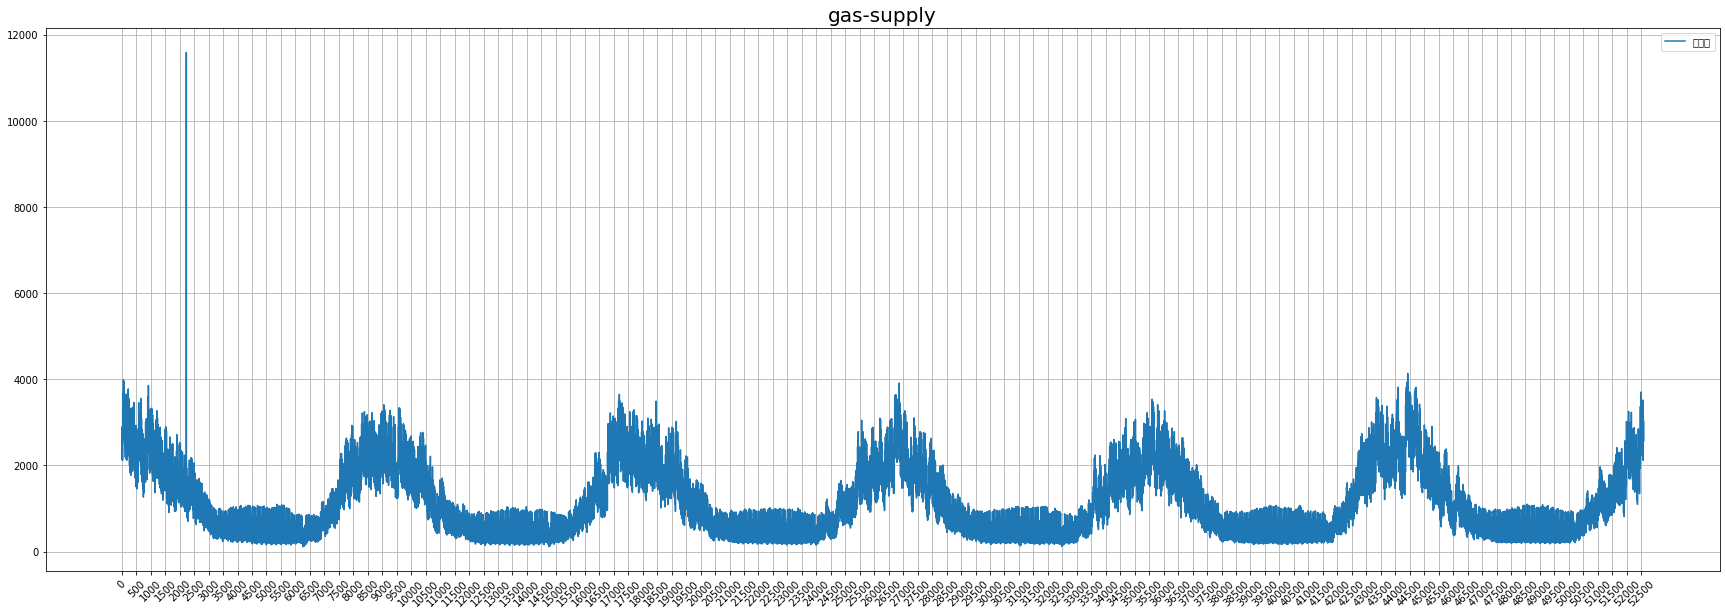

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



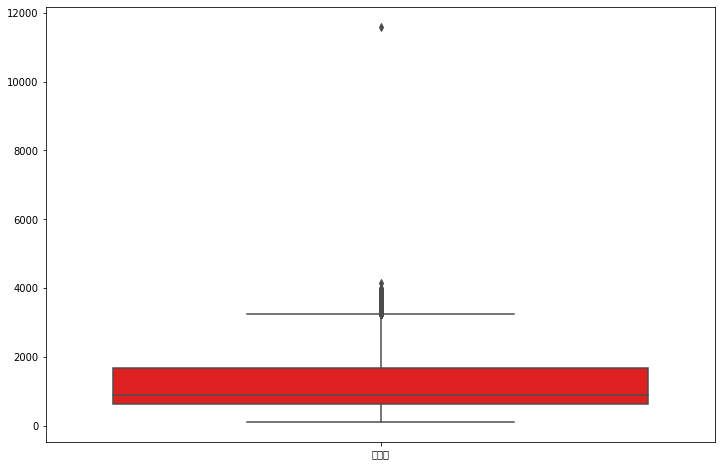

B


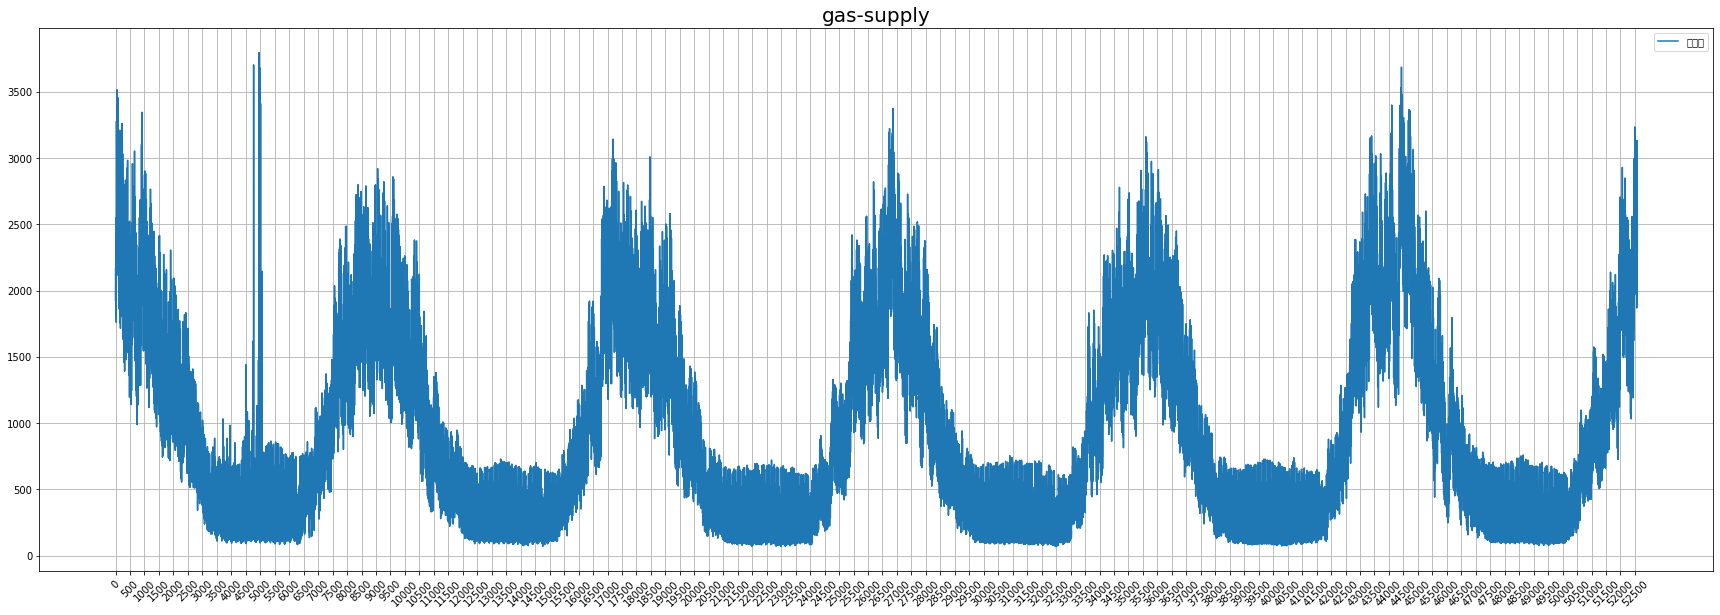

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



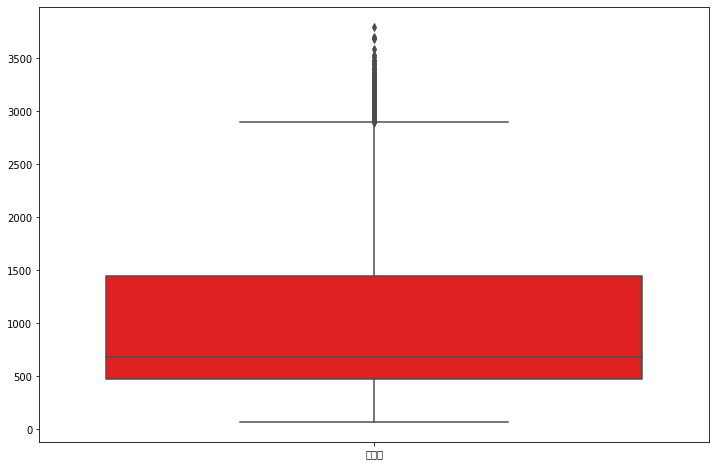

C


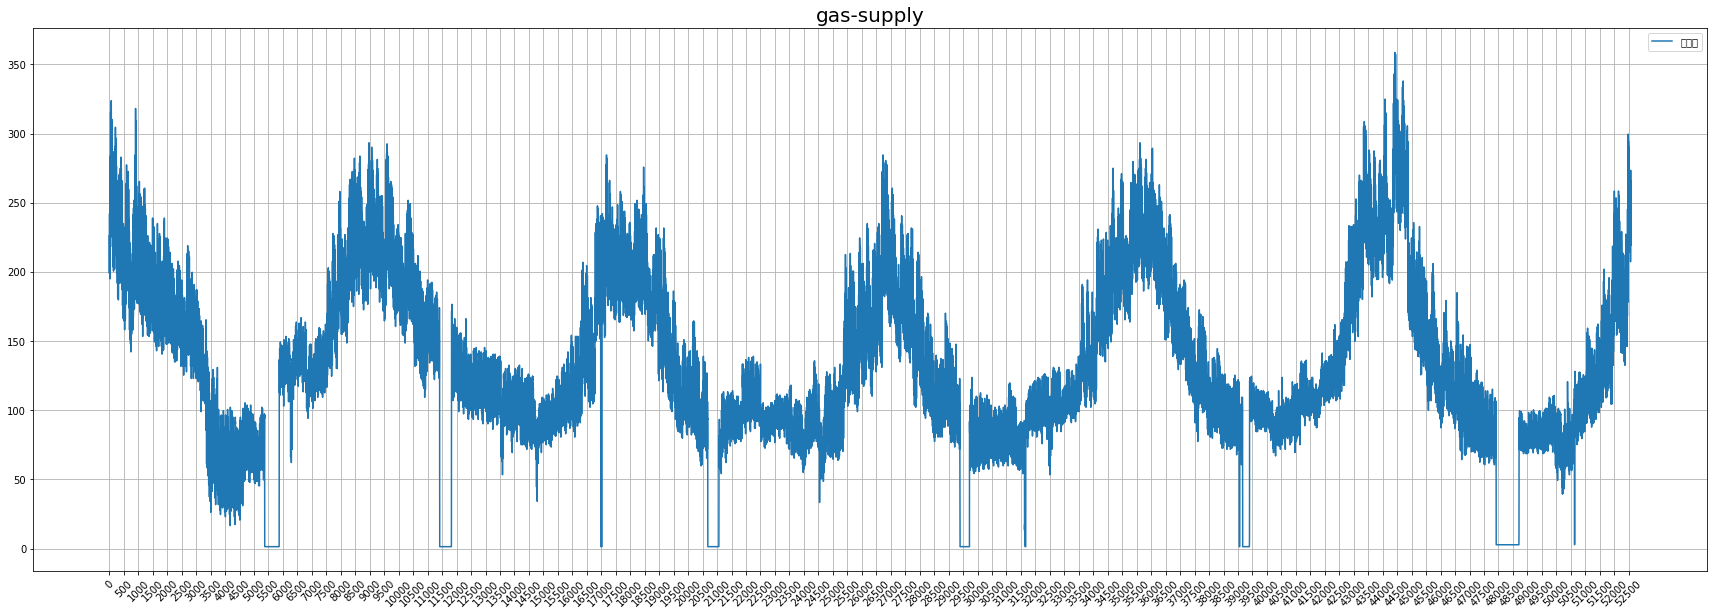

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



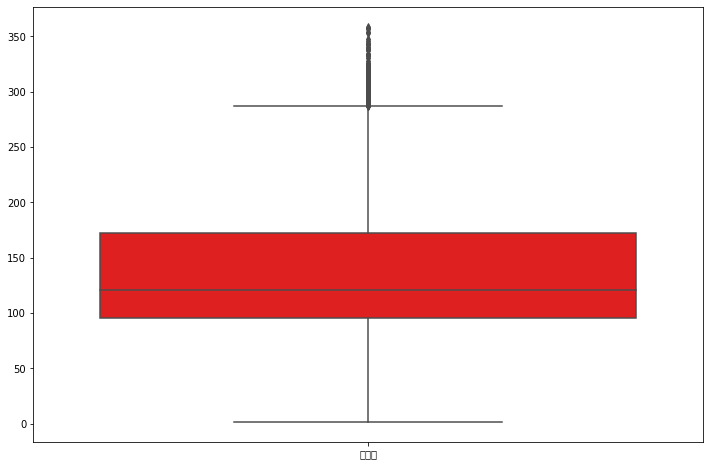

D


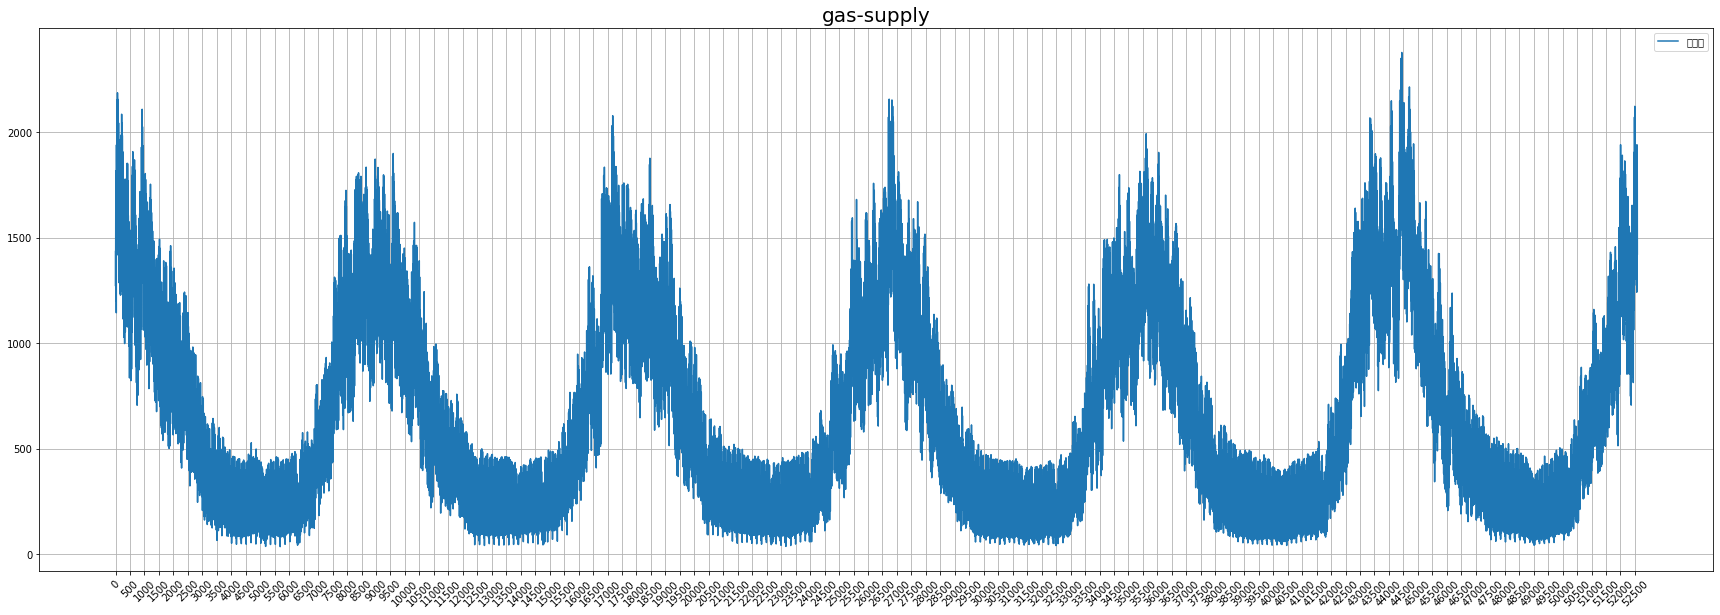

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



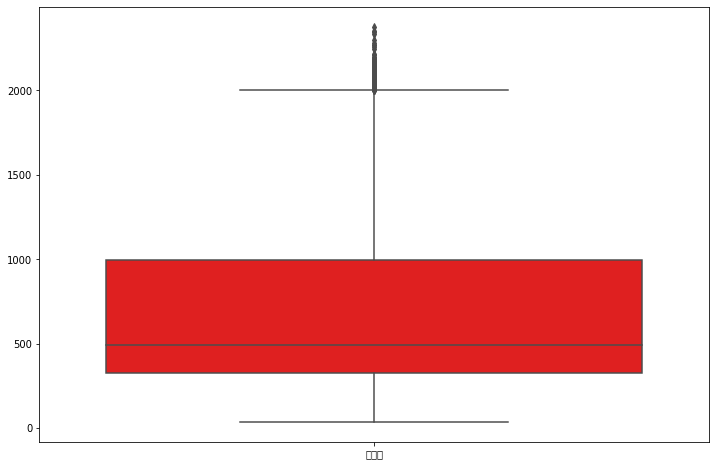

E


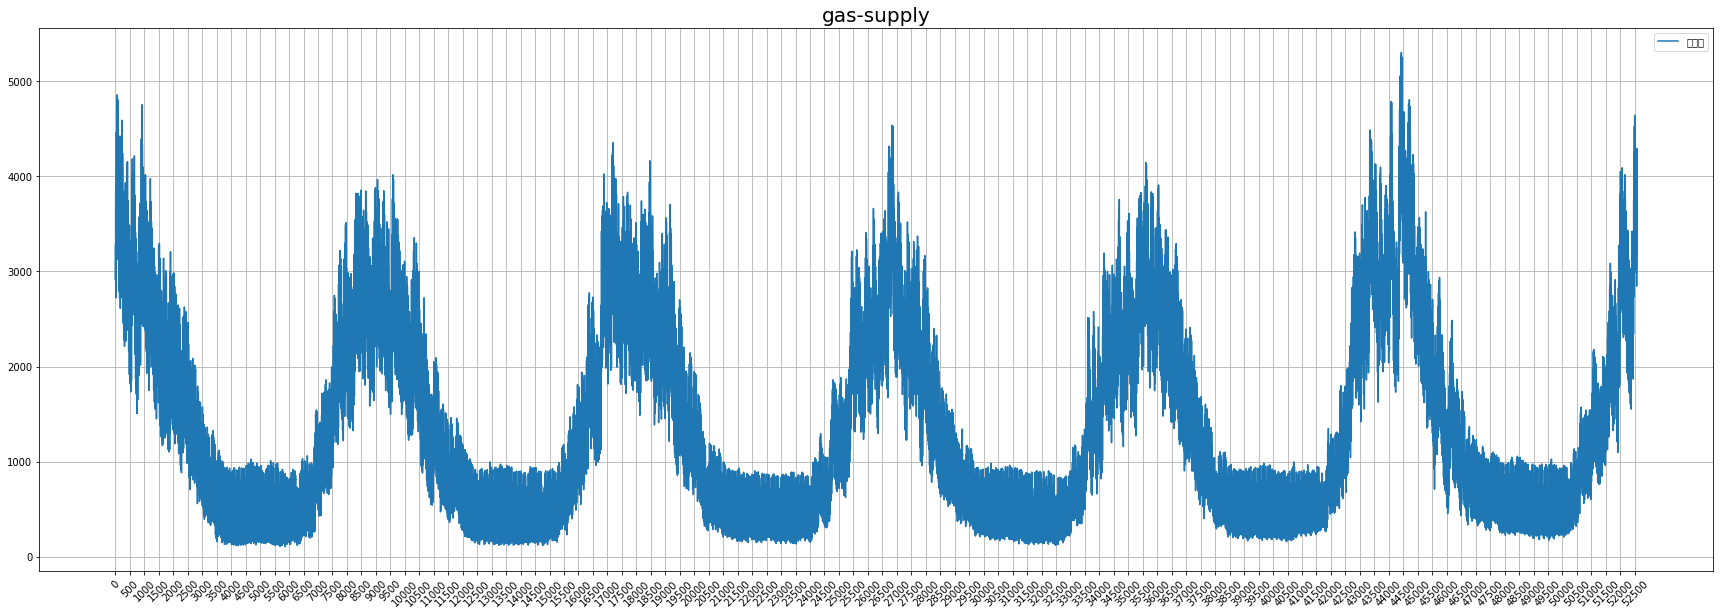

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



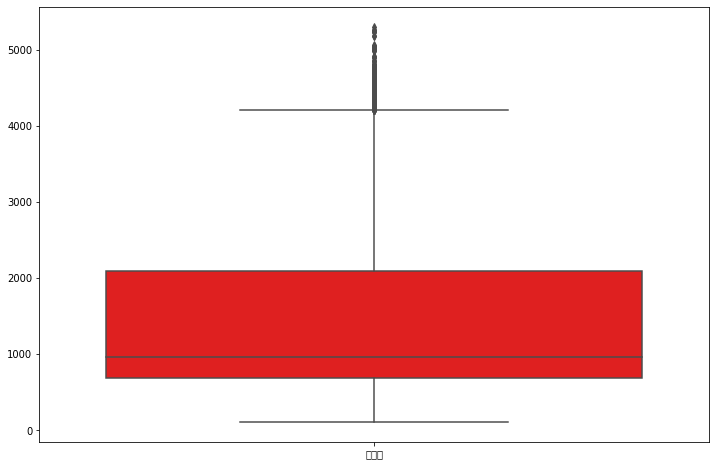

G


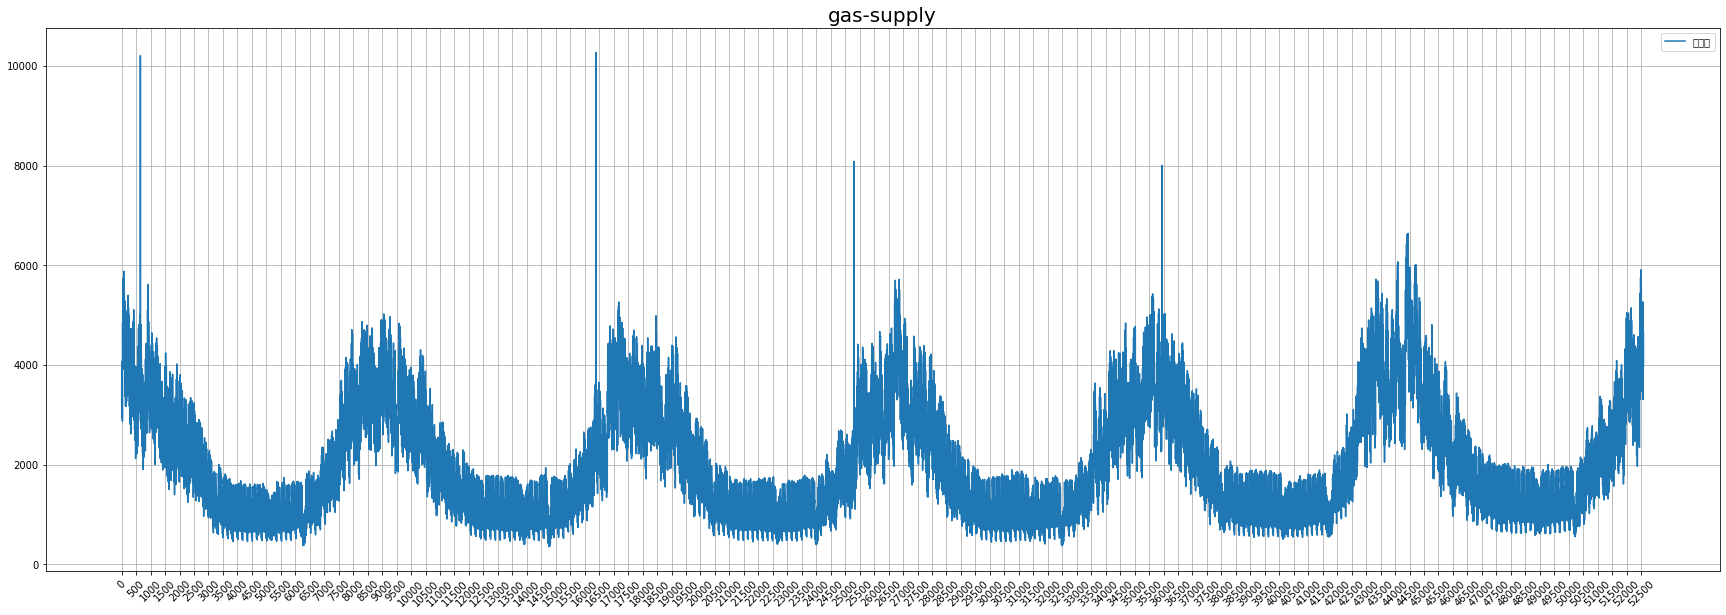

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



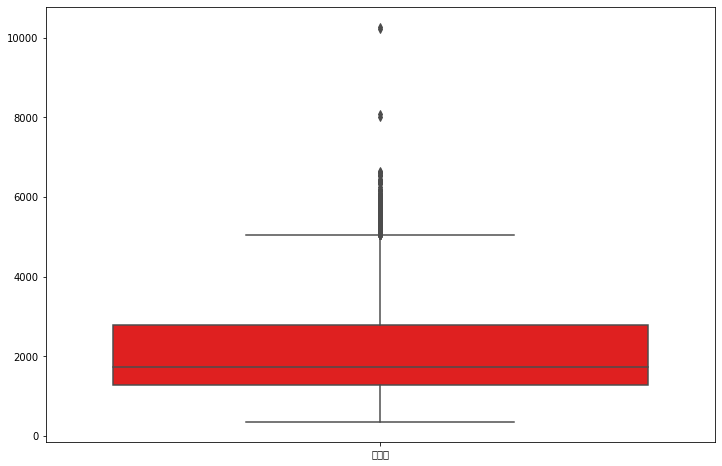

H


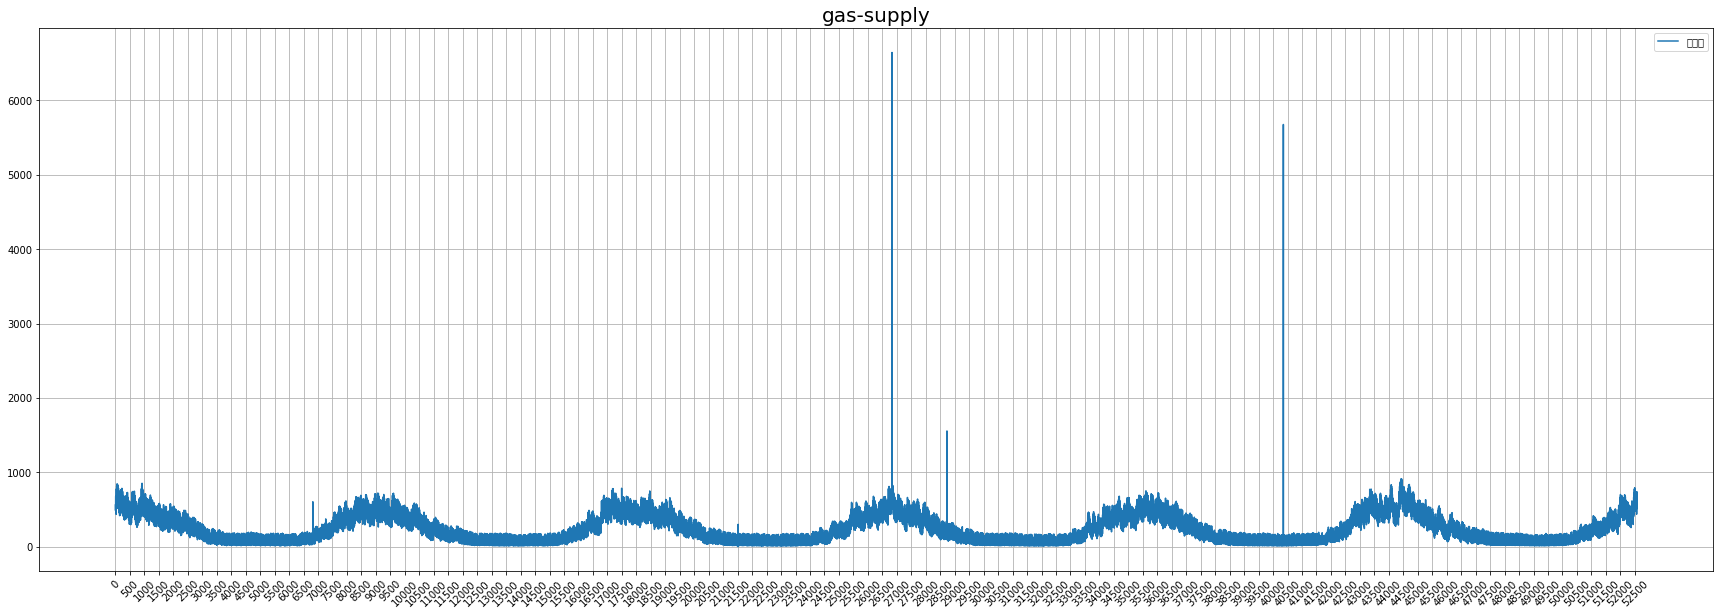

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47049 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44277 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44553 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 47049 missing from current font.



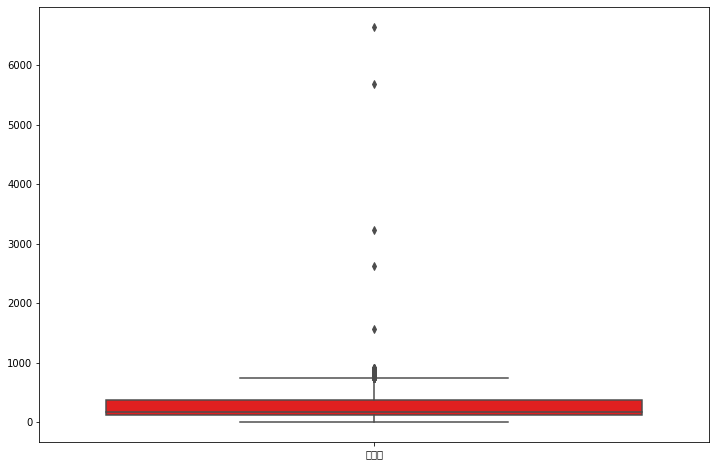

In [ ]:
def df_to_line_graph(df):
    size=len(df)
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

    cols=df.columns

    fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 설정
    ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

    for col in cols:
        ax.plot(df[col]) ## 선그래프 생성
        plt.legend([col])
        
    # plt.axis([x최소, x최대, y축최소, y축최대])

    plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
    plt.xticks(np.arange(0, size, 500))
    plt.grid(True)

    plt.title('gas-supply',fontsize=20) ## 타이틀 설정
    plt.show()

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df,color="red")
    plt.show()

for t in L:
    print(t)
    df_to_line_graph(df_dict[t][["공급량"]])

# 전처리

In [ ]:
def to_prophet(df):
    # prophet모델에 적용될 수 있도록 ds, y컬럼을 만든다
    new_df=df.copy()
    size=len(df)
    ds=[]
    for i in range(size):
        # print(i,df["연월일"][i])
        if df["시간"][i]==24:
            d=(datetime.datetime.strptime(df["연월일"][i],"%Y-%m-%d")+datetime.timedelta(days=1)).strftime("%Y-%m-%d")
            ds.append(datetime.datetime.strptime(d+" "+"00".zfill(2)+":00:00","%Y-%m-%d %H:%M:%S"))
        else:
            ds.append(datetime.datetime.strptime(df["연월일"][i]+" "+str(df["시간"][i]).zfill(2)+":00:00","%Y-%m-%d %H:%M:%S"))

    new_df["ds"]=ds
    new_df.drop(["시간","연월일","구분"],axis="columns",inplace=True)
    new_df.rename(columns={'공급량':"y"}, inplace=True)
    return new_df

df_dict_prophet={}
for t in L:
    df_dict_prophet[t]=to_prophet(df_dict[t])
    print(df_dict_prophet[t].isnull().sum())

y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64
y     0
ds    0
dtype: int64


# 이상치 제거

A
2
B


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



11
C
16
D
10
E
0
G
3
H
625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A


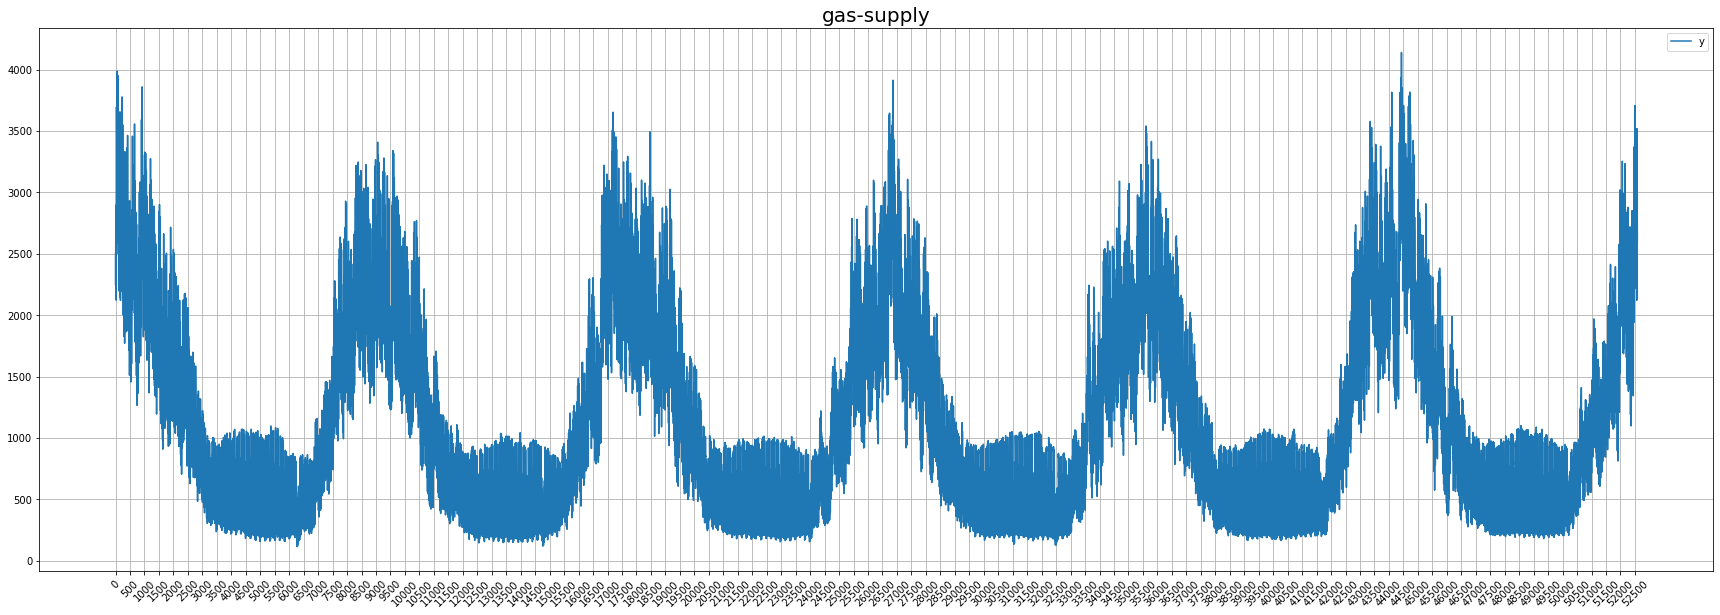

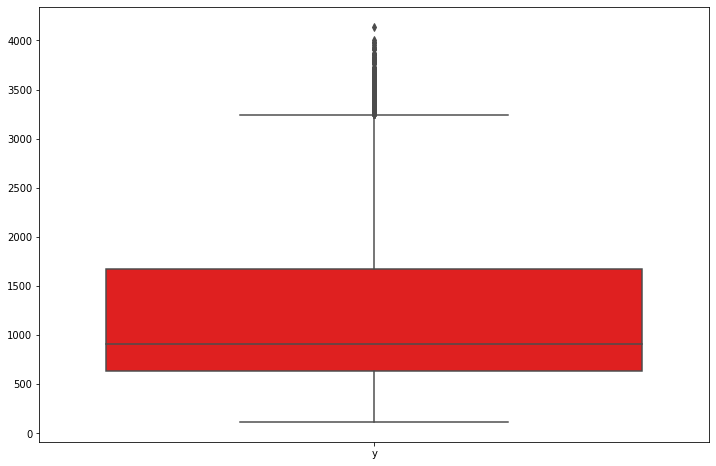

B


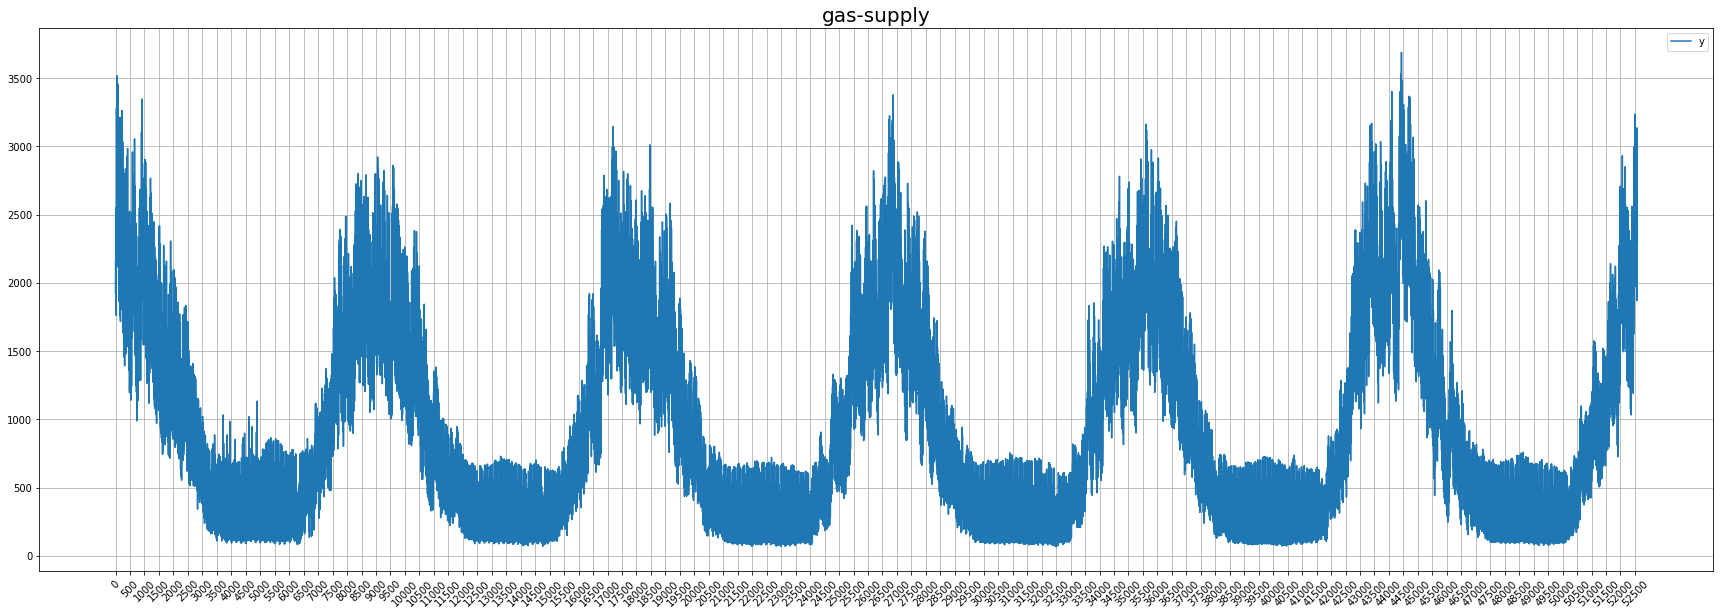

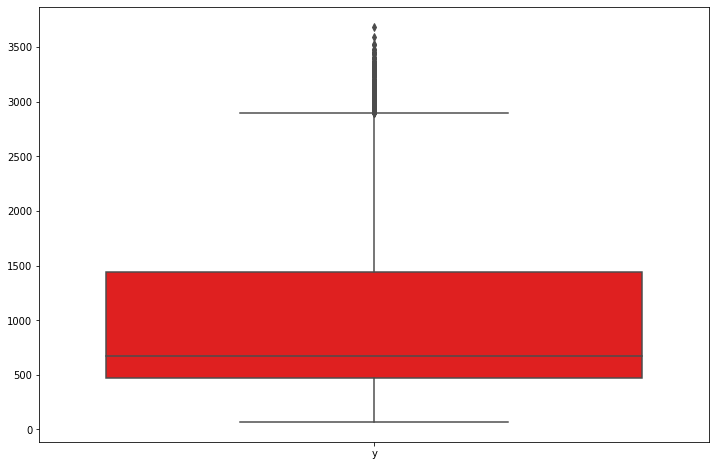

C


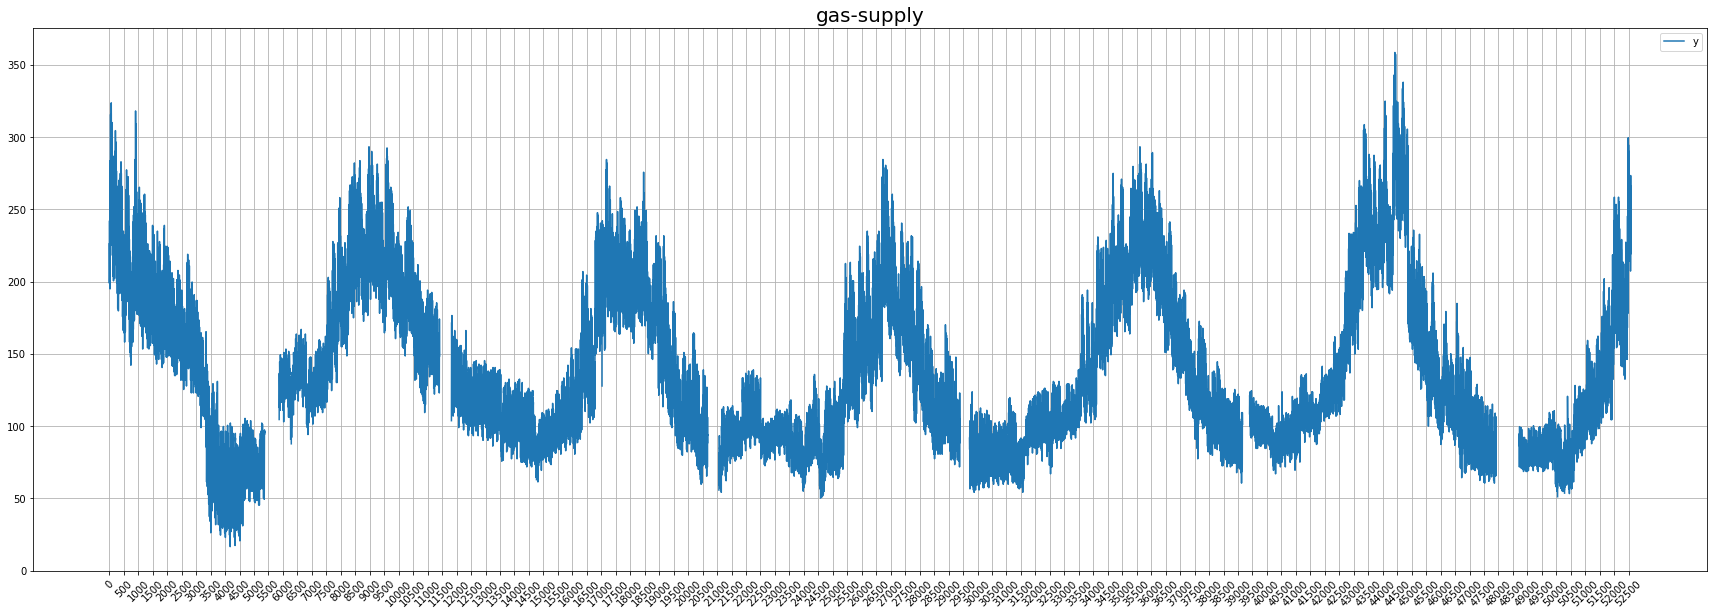

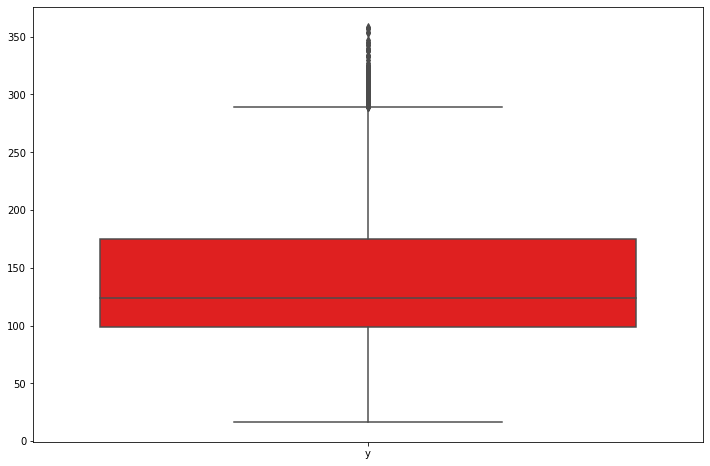

D


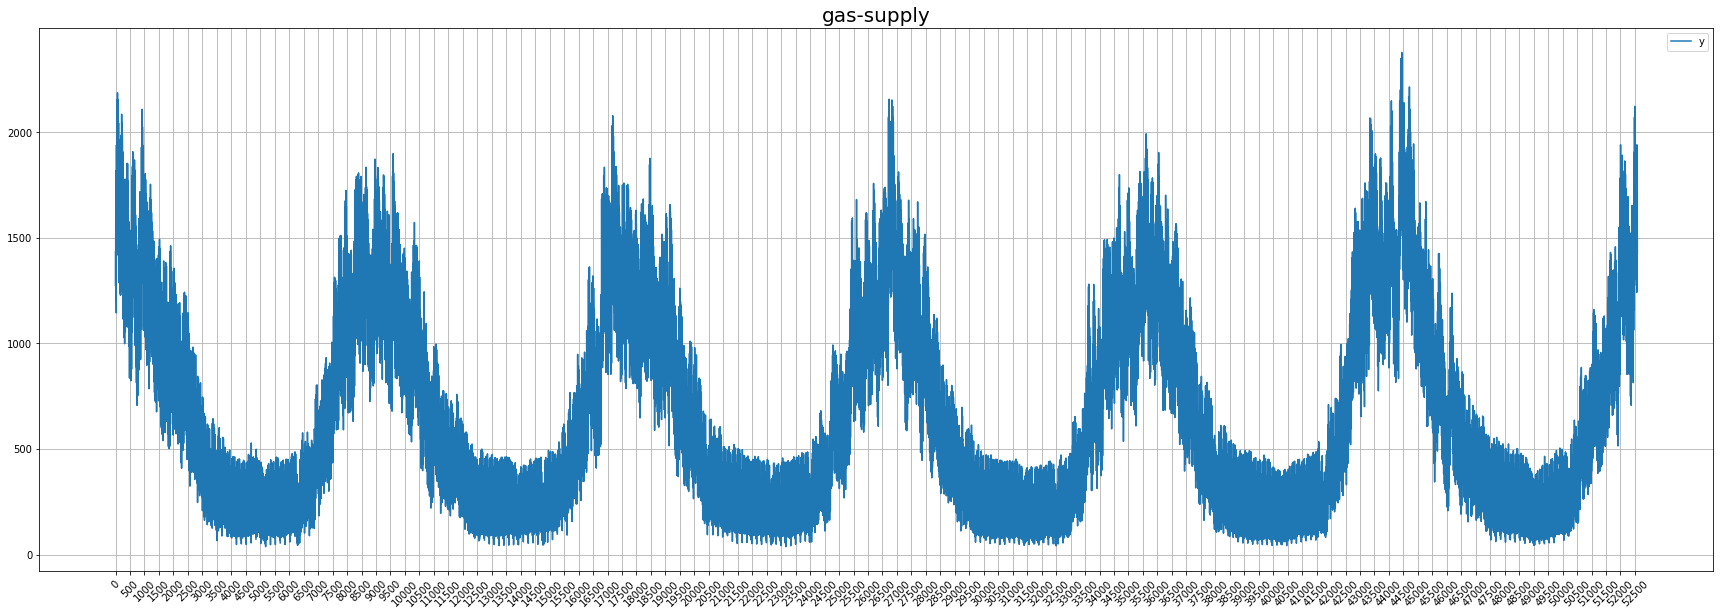

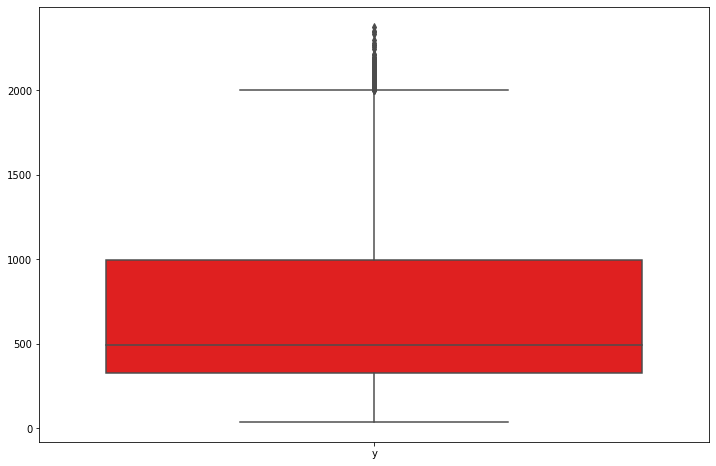

E


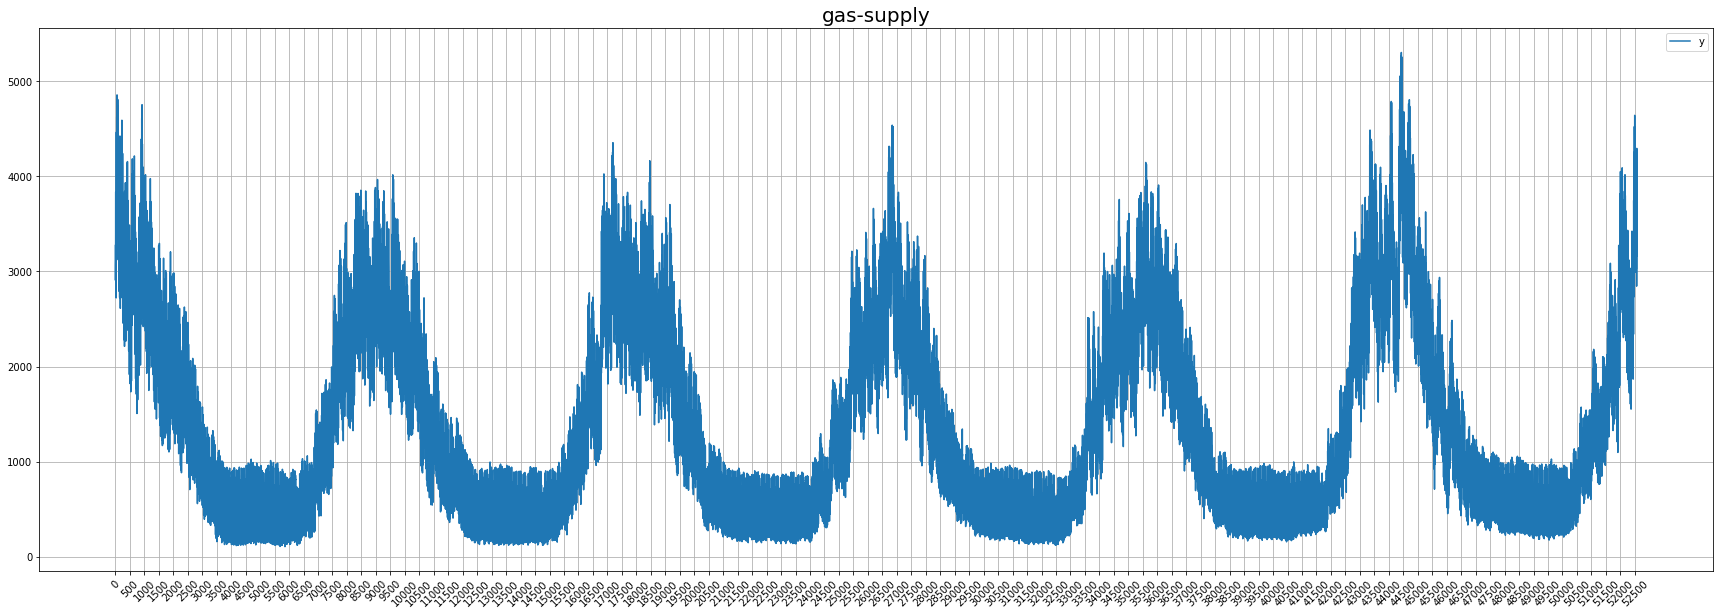

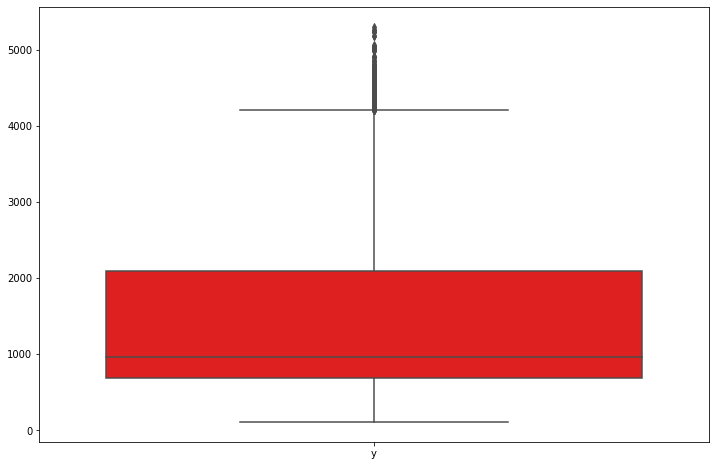

G


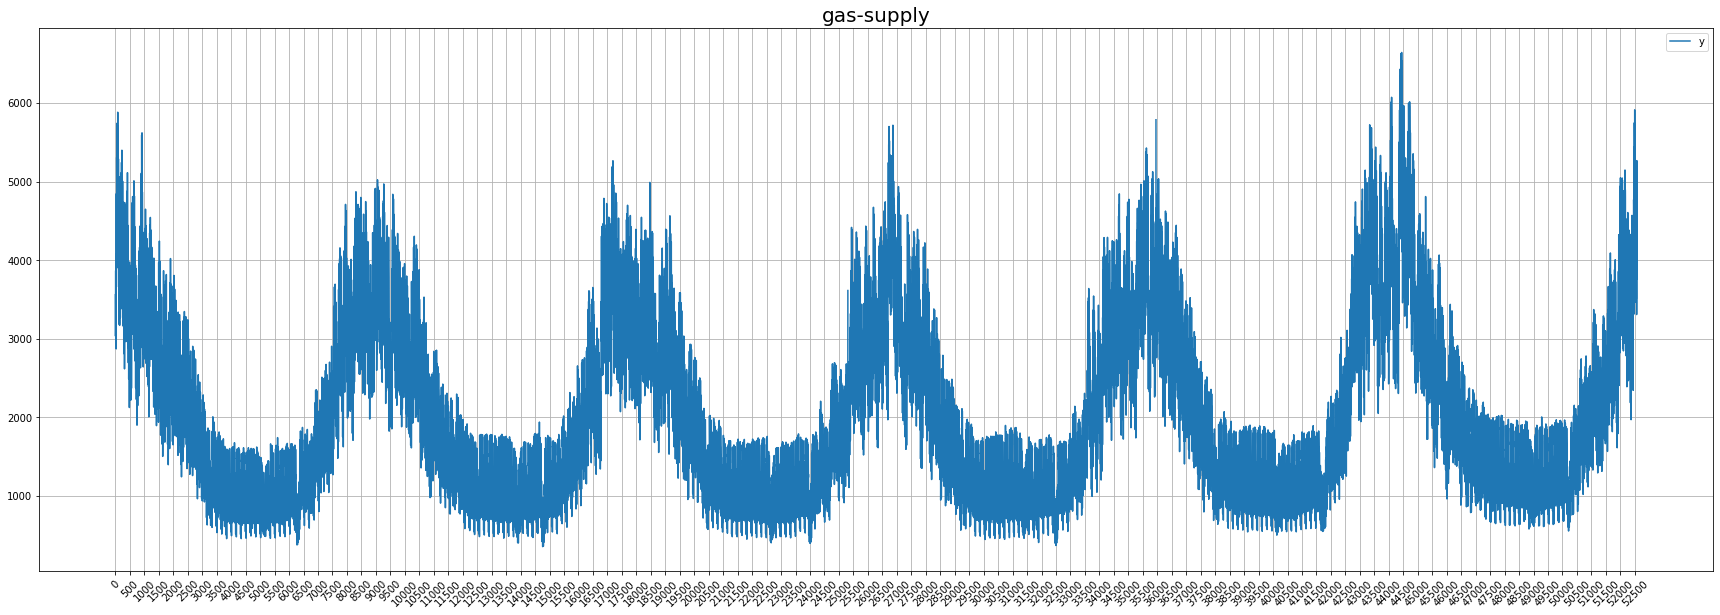

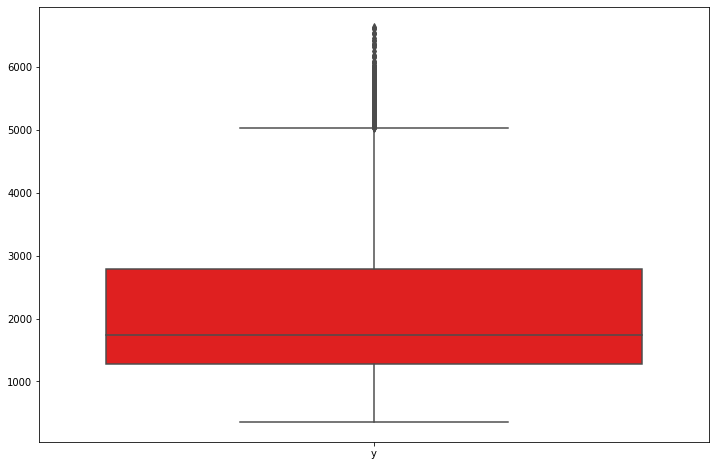

H


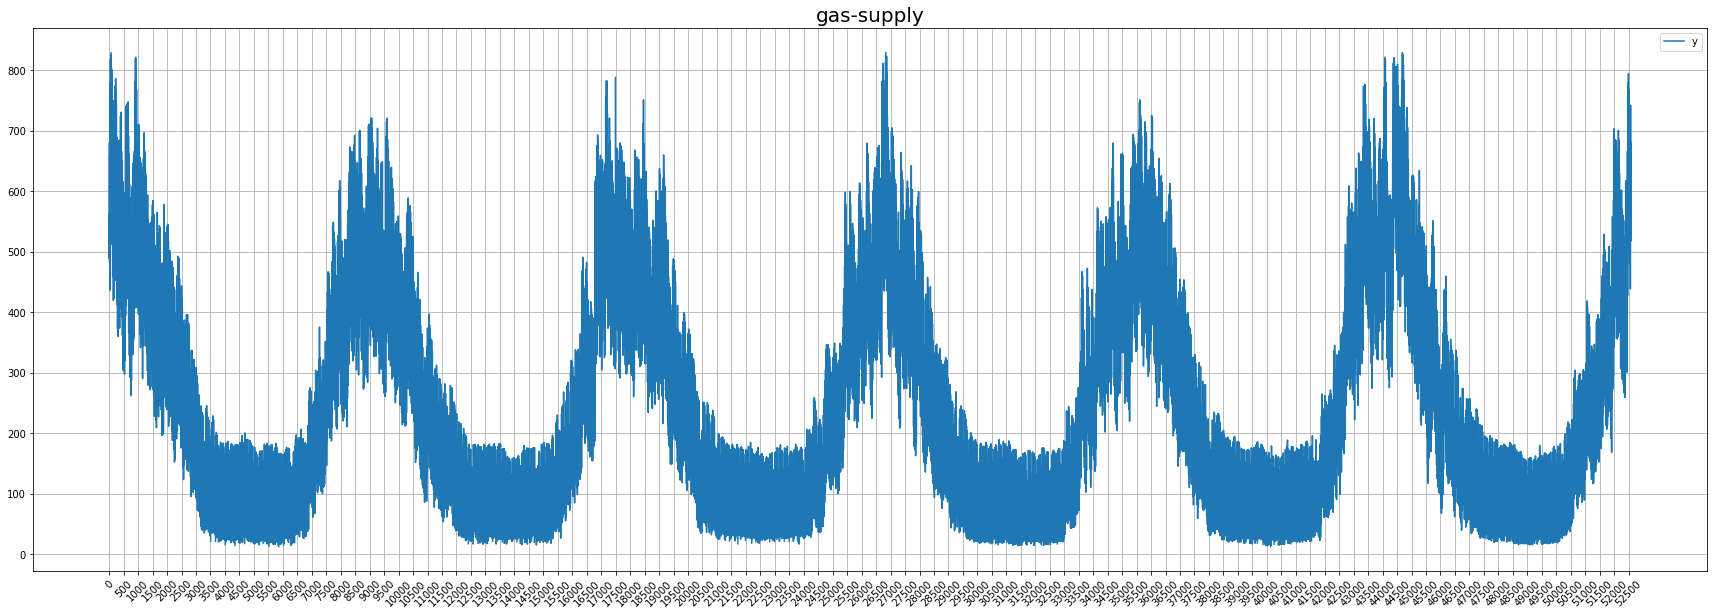

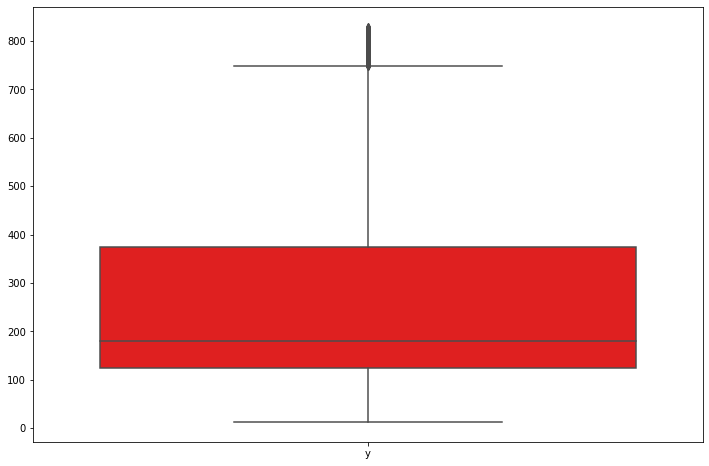

In [ ]:
# 양쪽과 50% 차이나는것 골라내기 
diff=0.5
for t in L:
    print(t)
    size = len(df_dict_prophet[t])

    removeL=[]

    for i in range(1,size-1):
        a=abs(df_dict_prophet[t]["y"].iloc[i]-df_dict_prophet[t]["y"].iloc[i-1])
        b=abs(df_dict_prophet[t]["y"].iloc[i]-df_dict_prophet[t]["y"].iloc[i+1])

        if (a/df_dict_prophet[t]["y"].iloc[i]>diff) and (b/df_dict_prophet[t]["y"].iloc[i]>diff):
            removeL.append(i)
            
    print(len(removeL))
    for remove_index in removeL:
        df_dict_prophet[t]["y"][remove_index]=None

# 이상치 None만들기
outlier = {"A":{"2000:2500":[10000,"up"]},
           "B":{"4000:5500":[1250,"up"]},
           "C":{"0:52500":[10,"down"],"14500:52500":[50,"down"],"16500:17500":[100,"down"],"6000:6500":[75,"down"],"13500:14000":[75,"down"],
                "14500:15000":[60,"down"],"32000:33000":[65,"down"]},
           "D":{},
           "E":{},
           "G":{"0:52500":[7000,"up"]},
           "H":{"0:52500":[830,"up"],"6500:7000":[600,"up"],"21000:22000":[200,"up"]}}

for t in L:
    for k in outlier[t]:
        a,b = map(int,k.split(":"))
        bound,f=outlier[t][k]
        for i in range(a,b):
            if f=="up":
                if df_dict_prophet[t]["y"][i]>bound:
                    df_dict_prophet[t]["y"][i]=None
            elif f=="down":
                if df_dict_prophet[t]["y"][i]<bound:
                    df_dict_prophet[t]["y"][i]=None

# 결측치화 된것 확인 
for t in L:
    print(t)
    df_to_line_graph(df_dict_prophet[t][["y"]])

# 보간 

In [ ]:
# # sample
# x=[1,2,3,5,7]
# y=[2,5,8,13,15]

# new_x=[1,2,3,4,5,6,7]
# f_linear = interpolate.interp1d(x, y, kind='linear')

# y_new_linear = f_linear(new_x)
# print(y_new_linear)
# plt.plot(x, y, "o", new_x, y_new_linear, 'x')
# plt.show()

A
B
C
D
E
G
H
A


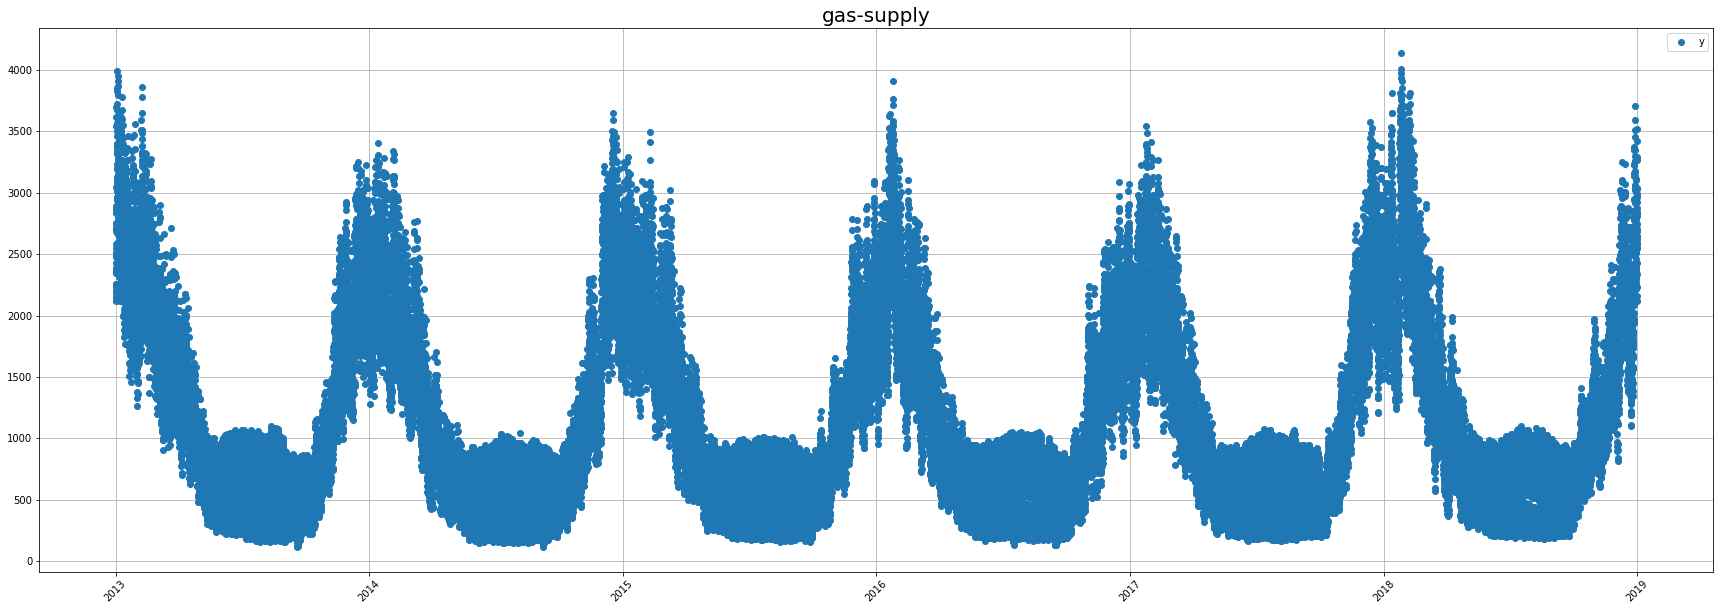

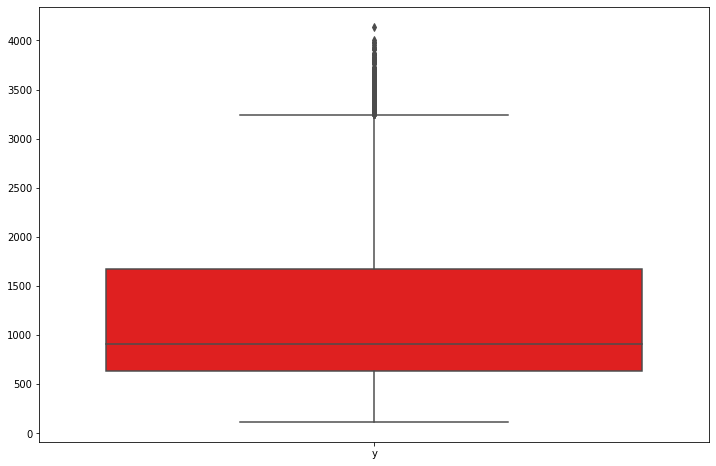

B


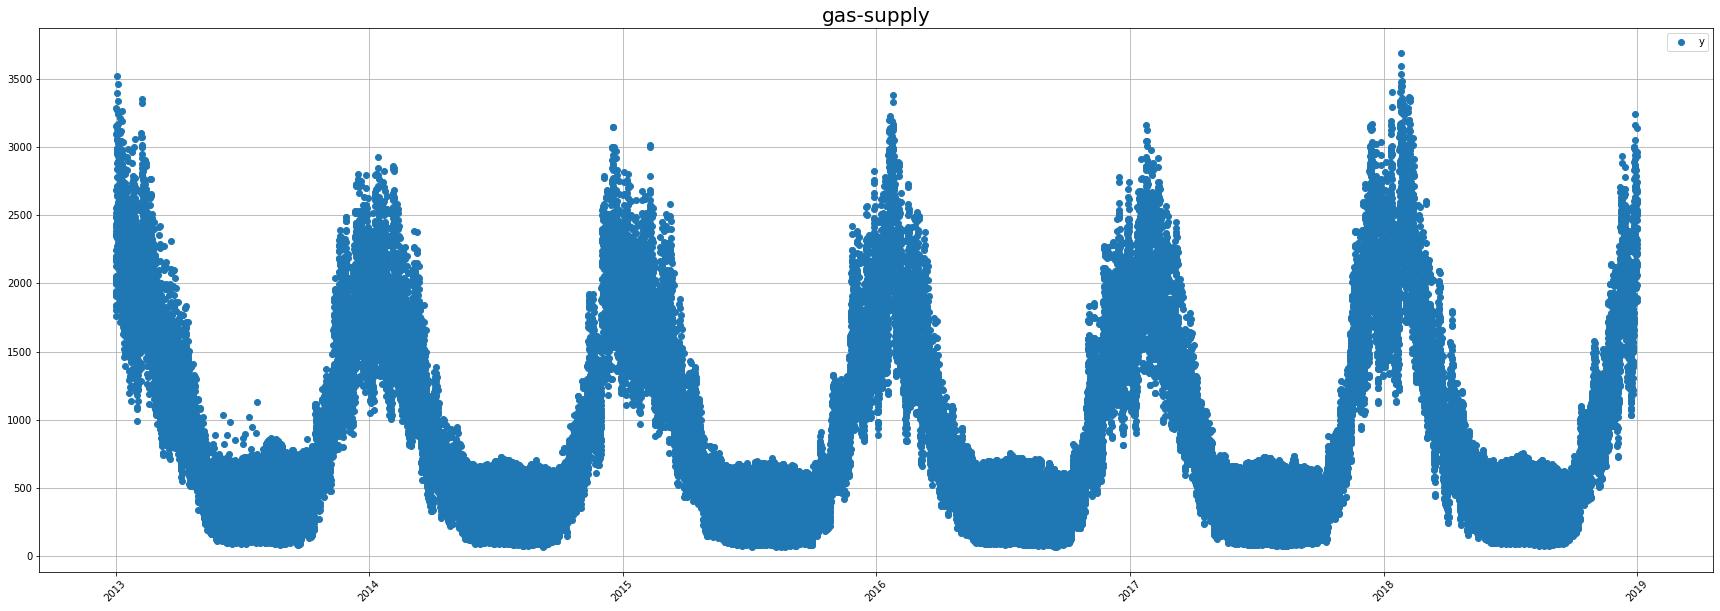

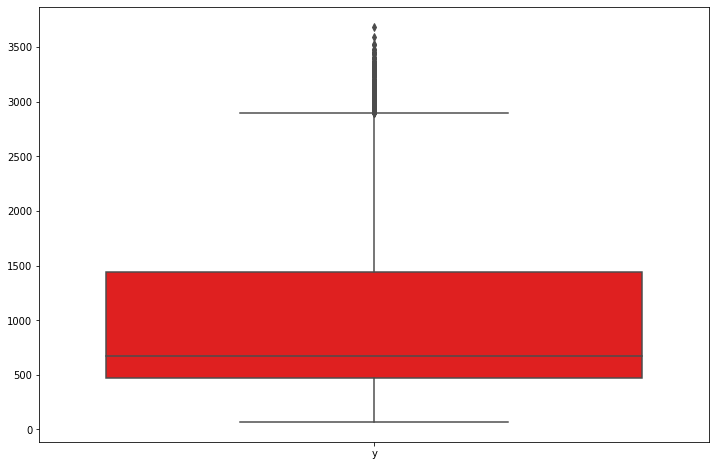

C


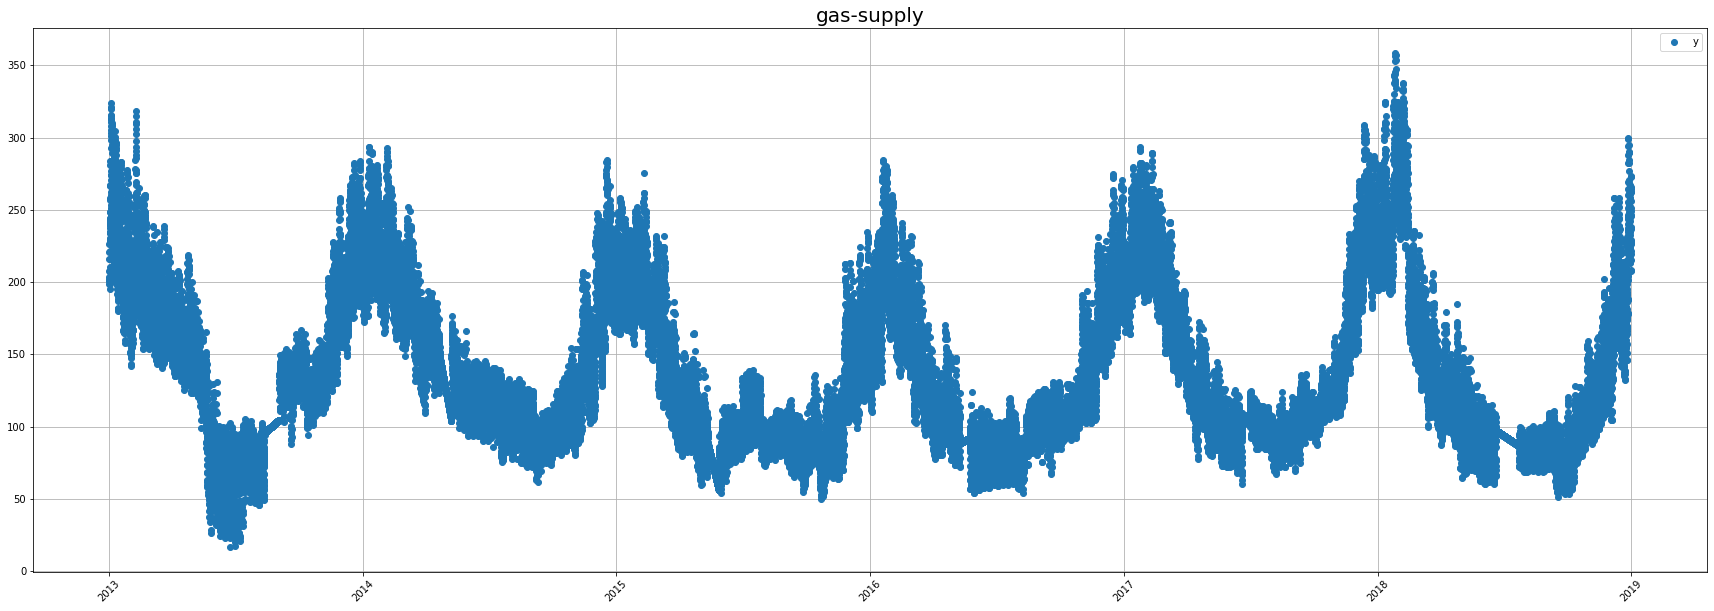

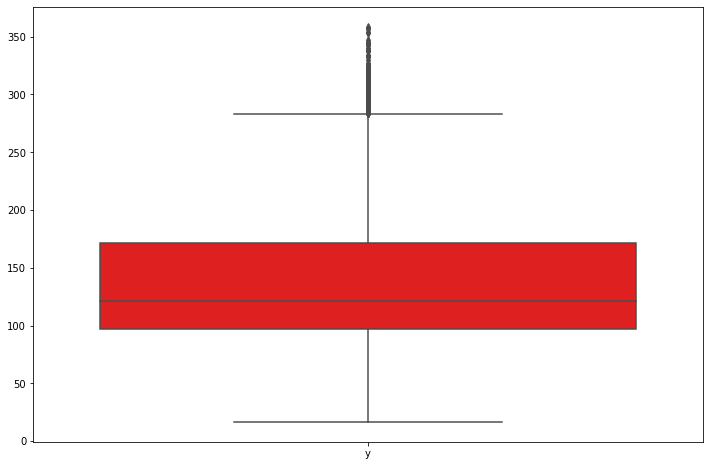

D


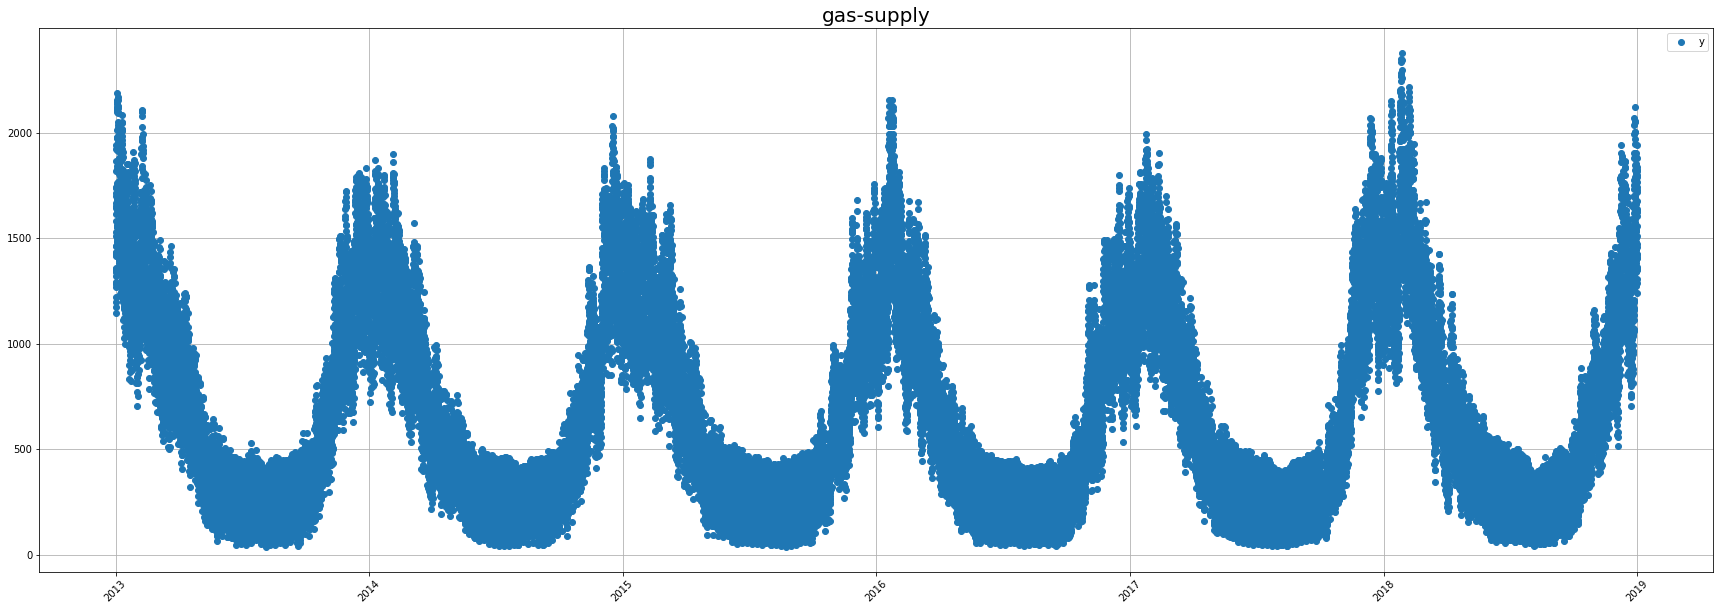

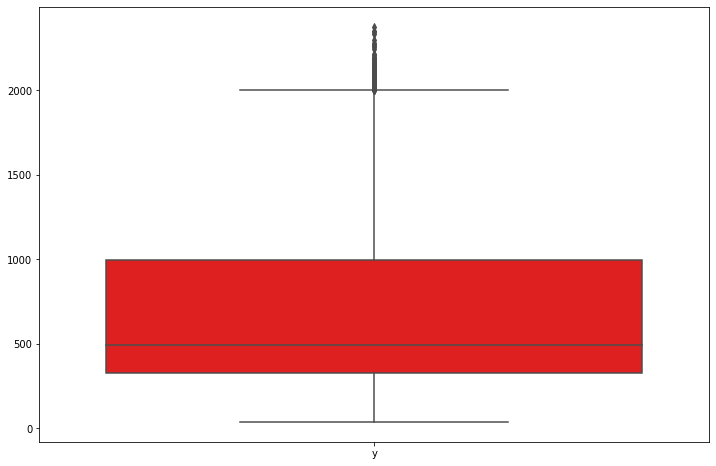

E


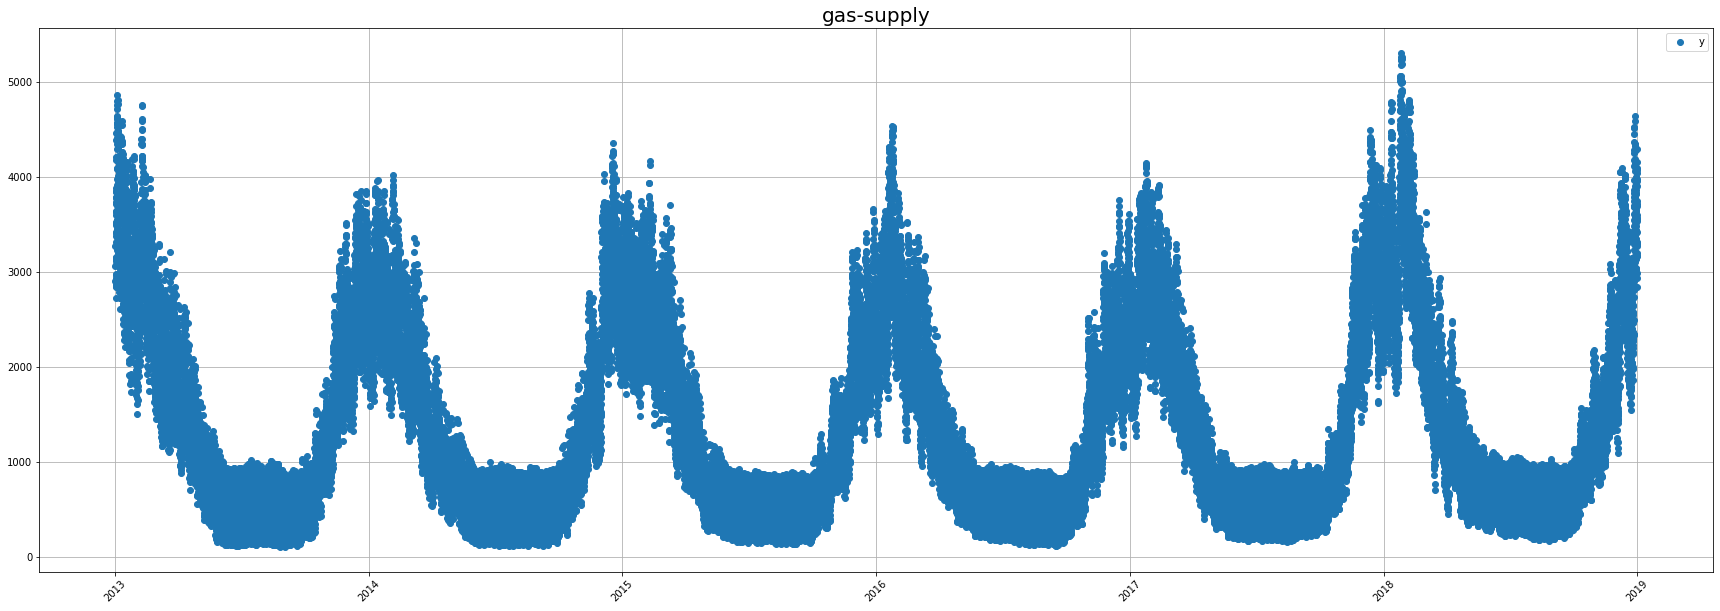

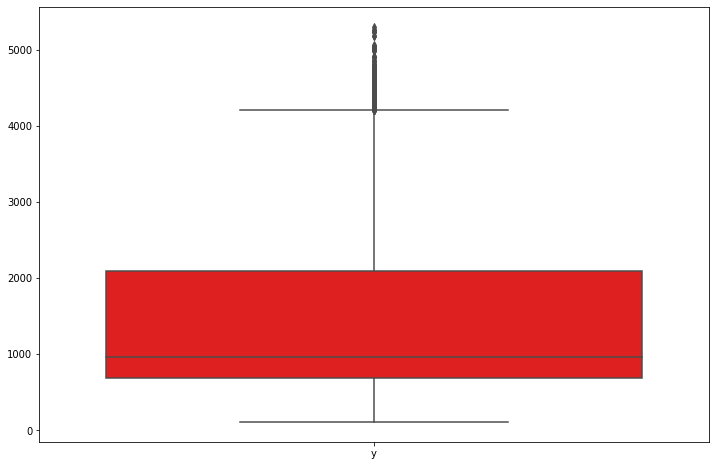

G


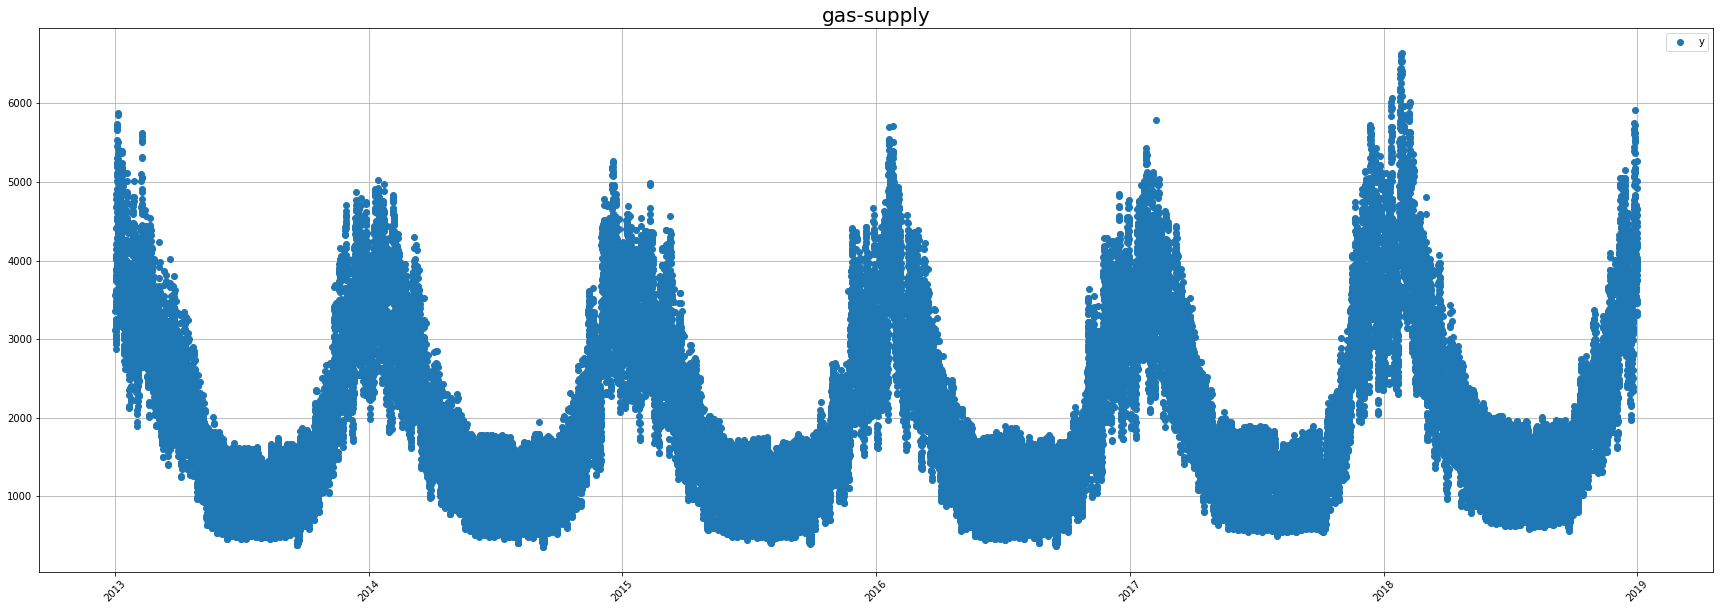

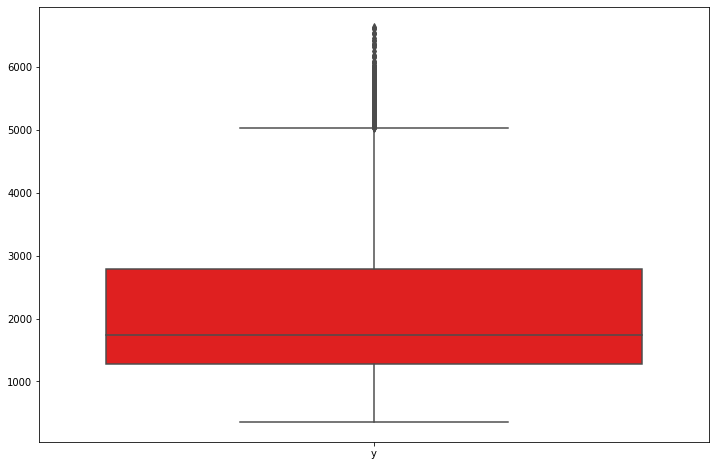

H


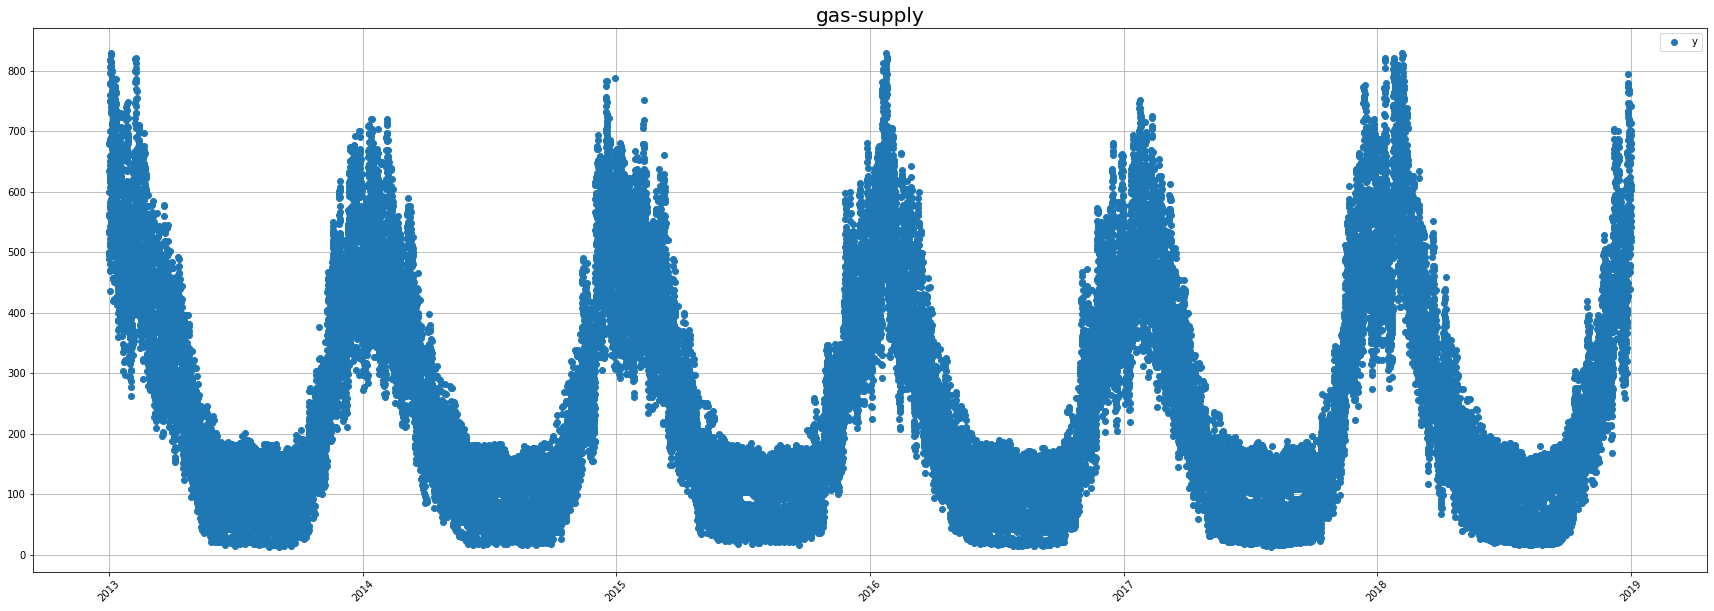

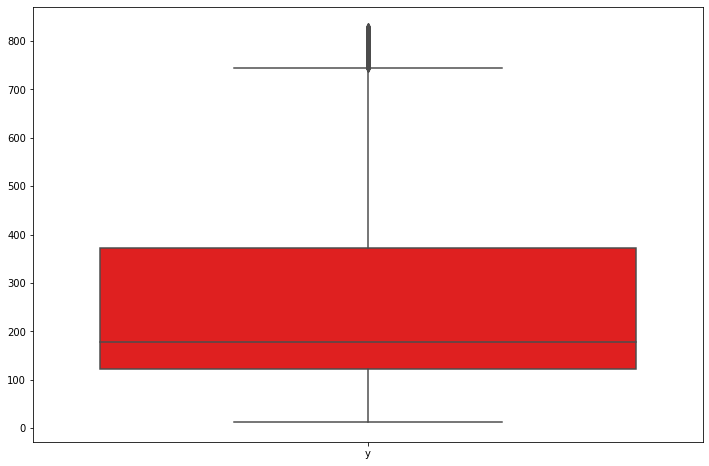

In [ ]:
def df_prophet_to_scatter(df):
    size=len(df)
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

    cols=df.columns

    fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 설정
    ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

    plt.plot(df["ds"], df["y"], 'o') ## 선그래프 생성    
    plt.legend(["y"])
        
    # plt.axis([x최소, x최대, y축최소, y축최대])

    plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
    # plt.xticks(np.arange(0, size, 500))
    plt.grid(True)

    plt.title('gas-supply',fontsize=20) ## 타이틀 설정
    plt.show()

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df,color="red")
    plt.show()

df_dict_prophet_interpolated=dict()

for alpha in L:
    print(alpha)
    dict_size=len(df_dict_prophet[alpha])

    # null없는 값으로 x,y생성
    x=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False].index)
    y=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False]["y"]) 

    #kind = linear(선형),cubic,nearest(가장가까운),next(이후),quadratic
    f_interpolate = interpolate.interp1d(x, y, kind='linear')

    # null있는값으로 바꿔서 보간
    new_x=list(df_dict_prophet[alpha]["y"].index)
    new_y=f_interpolate(new_x)

    df = df_dict_prophet[alpha].copy()
    df["y"]=new_y

    df_dict_prophet_interpolated[alpha]=df.copy()

# for alpha in L:
#     alpha="C"
#     dict_size=len(df_dict_prophet[alpha])

#     # null없는 값으로 x,y생성
#     x=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False].index)
#     y=list(df_dict_prophet[alpha].loc[df_dict_prophet[alpha]["y"].isna() == False]["y"]) 
#     new_x=list(df_dict_prophet[alpha]["y"].index)

#     my_spl = splrep(x,y,s=3) # 그래프 만들기
#     # print(my_spl[0])
#     # print(my_spl[1])
#     # print(my_spl[2])
#     new_y = splev(new_x, my_spl) # 그래프의 x에 해당하는 y점 찾기 

#     # 스탑!
#     df = df_dict_prophet[alpha].copy()
#     df["y"]=new_y

#     df_dict_prophet_interpolated[alpha]=df.copy()
#     break

for alpha in L:
    print(alpha)
    df_prophet_to_scatter(df_dict_prophet_interpolated[alpha])

# 학습 데이터 기간 조정

In [ ]:
# # 2016년 데이터부터!
# t = pd._libs.tslibs.timestamps.Timestamp("2016-01-01 01:00:00")
# start_index = df_dict_prophet_interpolated[alpha][df_dict_prophet_interpolated[alpha]["ds"]==t].index[0]
# for alpha in L:
#     df_dict_prophet_interpolated[alpha] = df_dict_prophet_interpolated[alpha][start_index:].copy()

# 정규화

In [ ]:
df_dict_prophet_interpolated_scaled = {}
scaler_dict = {}
for alpha in L:
    # 데이터 준비
    df_dict_prophet_interpolated_scaled[alpha] = df_dict_prophet_interpolated[alpha].copy()
    input_data = np.array(df_dict_prophet_interpolated[alpha]["y"]).reshape(-1,1)
    
    # 정규화
    scaler = StandardScaler()
    scaler_fit = scaler.fit(input_data)
    scaled_data = scaler_fit.transform(input_data)
    
    # (역정규화를 위한)스캐일러, 정규화된값 저장 
    scaler_dict[alpha]=scaler
    df_dict_prophet_interpolated_scaled[alpha]["y"]=scaled_data.flatten()
    
    # display(df_dict_prophet_interpolated_scaled[alpha])

In [ ]:
# 전처리
def dl_preprocess(alpha, sequence):
    alpha = alpha

    data=list(df_dict_prophet_interpolated_scaled[alpha]["y"])
    sequence=sequence

    x=[]
    y=[]

    for i in tqdm(range(train_size_per-sequence)):
        x.append(np.array(data[i:i+sequence]))
        y.append(np.array(data[i+sequence]))

    x=np.array(x)
    y=np.array(y)

    x=x.reshape(x.shape[0],x.shape[1],1)
    y=y.reshape(y.shape[0],1)

    return x,y

def lstm_func(x_train,y_train,epoch):
    dropout=0.3
    batch_size=14
    verbose=1
    epoch=epoch

    # LSTM
    model = Sequential()
    model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(dropout)) 
    model.add(LSTM(64, activation="relu", return_sequences=False))
    model.add(Dropout(dropout)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')

    model_fit = model.fit(x_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epoch,
                            verbose=verbose)

    # 예측값 순차 적으로 추출
    now_x=np.concatenate((x[-1][1:],np.array([y[-1]])),axis=0)
    test_y=[]
    for i in tqdm(range(test_size_per)):
        now_y = model.predict(np.array([now_x]))
        test_y.append(now_y[0][0])
        now_x=np.concatenate((now_x[1:],now_y),axis=0)
        
    return test_y

def reverse_scale(alpha,test_y):
    # 역정규화 
    scaler = scaler_dict[alpha]
    inverse_scaled_data = scaler.inverse_transform(test_y)

    tempL=list(df_dict_prophet_interpolated[alpha]["y"])
    tempL.extend(list(inverse_scaled_data))
    tempDf = pd.DataFrame(tempL)
    return tempDf

def df_to_scatter(df):
    size=len(df)
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

    cols=df.columns

    fig = plt.figure(figsize=(30, 10)) ## 캔버스 생성
    fig.set_facecolor('white') ## 캔버스 색상 설정
    ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

    plt.plot(df[0], 'o') ## 선그래프 생성    
    plt.legend(["y"])
        
    # plt.axis([x최소, x최대, y축최소, y축최대])

    plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
    # plt.xticks(np.arange(0, size, 500))
    plt.grid(True)

    plt.title('gas-supply',fontsize=20) ## 타이틀 설정
    plt.show()

    plt.figure(figsize=(12,8))
    sns.boxplot(data=df,color="red")
    plt.show()

my_y_hat=[]
epoch=500
for alpha in L:
    if alpha=="A":
        continue
    x,y = dl_preprocess(alpha,24)
    test_y = lstm_func(x,y,epoch)
    df = reverse_scale(alpha,test_y)

    with open(path+f"/dl_pickle/{alpha}.pickle",'wb') as fw:
        pickle.dump(test_y, fw)
    
    print(df[0].iloc[-test_size_per:])
    my_y_hat.extend(df[0].iloc[-test_size_per:])
    df_to_scatter(df)

100%|██████████| 52560/52560 [00:00<00:00, 248945.42it/s]


Epoch 1/500
3755/3755 [==============================] - 145s 38ms/step - loss: 0.1796
Epoch 2/500
3755/3755 [==============================] - 143s 38ms/step - loss: 0.1318
Epoch 3/500
3755/3755 [==============================] - 154s 41ms/step - loss: 0.1203
Epoch 4/500
3755/3755 [==============================] - 143s 38ms/step - loss: 0.1137
Epoch 5/500
3755/3755 [==============================] - 140s 37ms/step - loss: 0.1115
Epoch 6/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1079
Epoch 7/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1064
Epoch 8/500
3755/3755 [==============================] - 139s 37ms/step - loss: 0.1041
Epoch 9/500
3755/3755 [==============================] - 142s 38ms/step - loss: 0.1033
Epoch 10/500
3755/3755 [==============================] - 141s 38ms/step - loss: 0.1013
Epoch 11/500
3755/3755 [==============================] - 140s 37ms/step - loss: 0.1006
Epoch 12/500
3755/3755 [=================

# 머신러닝(결과다 같은수 나옴, 추가연구필요)

In [ ]:
# # bagging
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor

# # boosting
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

# # 전처리
# alpha = "C"

# data=list(df_dict_prophet_interpolated_scaled[alpha]["y"])
# sequence=7

# x=[]
# y=[]

# for i in tqdm(range(train_size_per-sequence)):
#     x.append(data[i:i+sequence])
#     y.append(data[i+sequence])

# my_model = LGBMRegressor().fit(x,y)

# # 예측값 적용!
# now_x = data[-sequence:]
# test_y = []

# for i in tqdm(range(test_size)):
#     now_y = my_model.predict([now_x])
#     test_y.append(now_y[0])
    
#     now_x.extend(now_y)
#     now_x = now_x[1:]

# # 역정규화 ! 
# my_y_hat = []

# scaler = scaler_dict[alpha]
# inverse_scaled_data = scaler.inverse_transform(test_y)

# # 시각화
# tempL=list(df_dict_prophet_interpolated[alpha]["y"])
# tempL.extend(list(inverse_scaled_data))
# tempDf = pd.DataFrame(tempL)


# df_to_line_graph(tempDf)

# now_x = data[-sequence:]
# test_y = []

# for i in range(test_size):
#     now_y = my_LinearRegression.predict([now_x])
#     test_y.append(now_y[0])
    
#     now_x.extend(now_y)
#     now_x = now_x[1:]

# # 역정규화 
# my_y_hat = []

# scaler = scaler_dict[alpha]
# inverse_scaled_data = scaler.inverse_transform(test_y)

# test코드는 
- 7개의 지점 L=["A","B","C","D","E","G","H"]이 존재한다
- 7개의 지점은 각각 2160개씩의 데이터를 갖고있다
- 2160은 (20190101 1시 ~ 20190331 24시) = 24*(31+28+31) 이다!
- 지점별로 2160개를 오름차순으로 예측하고 이어붙이면 된다!

In [ ]:
total=0
for a in L:
    now_size=len(test_df[test_df['일자|시간|구분'].str.contains(a)])
    total+=now_size
    
print(total==test_size)
print(now_size==24*(31+28+31))

True
True


# 제출파일만들기

In [ ]:
# 제출파일 만들기
def get_file_name():
    def returnNum(s):
        return int(s[:-4])

    files = os.listdir(path+"/sub")
    new_file_num = max(list(map(returnNum,files)))+1
    file_name = str(new_file_num)+".csv"
    return file_name 

sub_df = sample_df.copy()
sub_df["공급량"]=my_y_hat
file_name = get_file_name()
print(file_name)
sub_df.to_csv(path+"/sub/"+file_name,index=False)

# 제출

In [ ]:
# 제출
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

from dacon_submit_api import dacon_submit_api 

sub_memo = "dl테스트" # !!!!!!메모!!!!!!
path_for_sub = path+"/sub/"+file_name
token = "my_token"
my_id = "235830"
my_team = "씩씩한오리너구리"


result = dacon_submit_api.post_submission_file(
    path_for_sub, 
    token, 
    my_id, 
    my_team, 
    sub_memo )

In [ ]:
# with open(path+'/prophet.pickle','wb') as fw:
#     pickle.dump(model, fw)

# with open(path+'/prophet.pickle', 'rb') as fr:
#     loaded_model = pickle.load(fr)